# Cascade Satellite

In [22]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf, rlocus, step, feedback, lsim, bode, ss, tf
s = tf('s')

from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


## Satellite

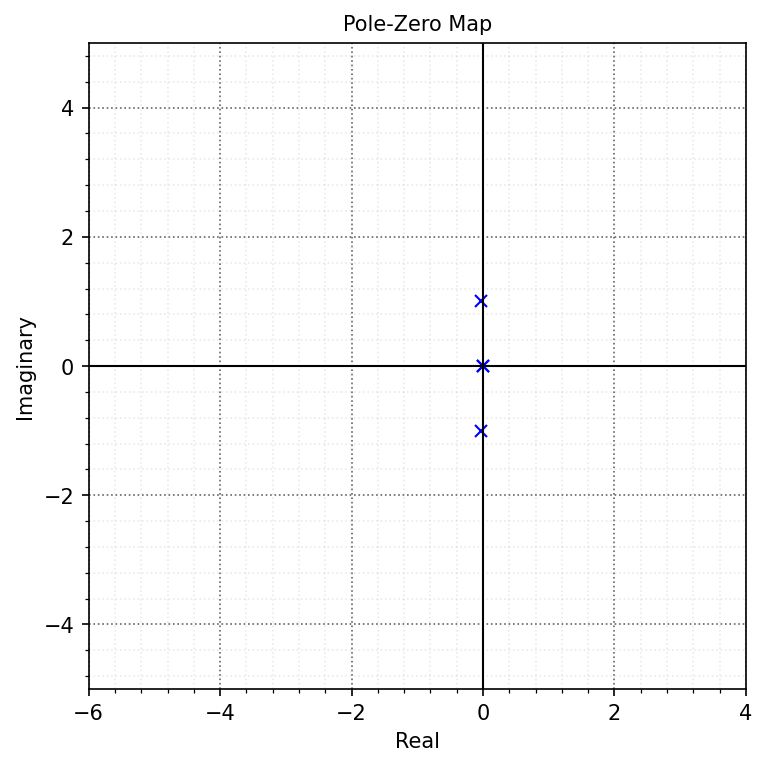

In [23]:
# Constants for the model
# Physical parameters of the satellite known to the controller
Js = 10.0      # kg m^2
Jp = 1.0      # kg m^2
k = 1.0         # N m 
b = 0.05      # N m s

Ts = 0.01      # sample time for simulation

G_solar = tf([b/Jp, k/Jp], [1, b/Jp, k/Jp])
G_RB = tf([1], [Js+Jp,0,0])
w_flex = np.abs(G_solar.poles())[0]

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
my_pzmap(G_solar*G_RB,ax=ax)
ax.set_xlim(-6,4)
ax.set_ylim(-5,5)
nicegrid(ax)
plt.show()

In [24]:
# design parameters for the RB controller
zeta = 0.707
wn = 5.0
# pick gains for the attitude controller
Kp_RB = wn**2*(Js+Jp)
Kd_RB = 2*zeta*wn*(Js+Jp)

PD_RB = tf([Kd_RB, Kp_RB], [1])
PD_RB


TransferFunction(array([  77.770,  275.000]), array([1]))


Found breakin/out at K = 80.088
At possible locations s = -4.634

Found breakin/out at K = -0.000
At possible locations s = 0.000


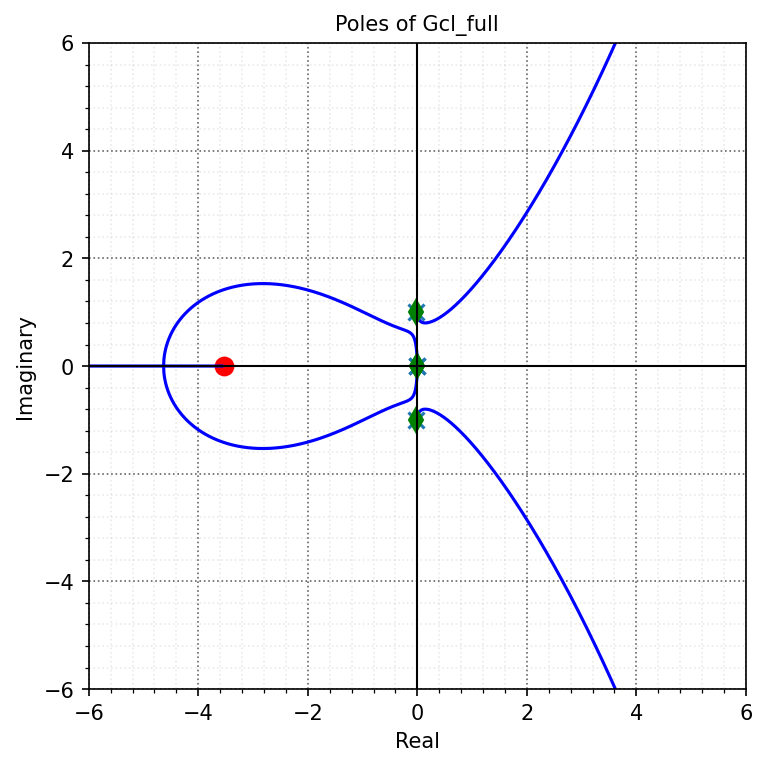

In [25]:
#try to implement PD_full on full system
# Full Loop TF
L_full = G_solar * G_RB * PD_RB

Gcl_full = tf(L_full.num[0][0], np.polyadd(L_full.den[0][0], L_full.den[0][0]))

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlocus(L_full, Root_Locus_gains(L_full), grid=False,ax=ax)
plt.plot(Gcl_full.poles().real, Gcl_full.poles().imag, 'cd', markersize=10)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles of Gcl_full')
plt.grid(True)
ax.set_ylim(-6,6)
ax.set_xlim(-6,6)
color_rl(ax)
nicegrid(ax)   
plt.show()



Found breakin/out at K = 2.001
At possible locations s = -7.072

Found breakin/out at K = -0.000
At possible locations s = 0.000


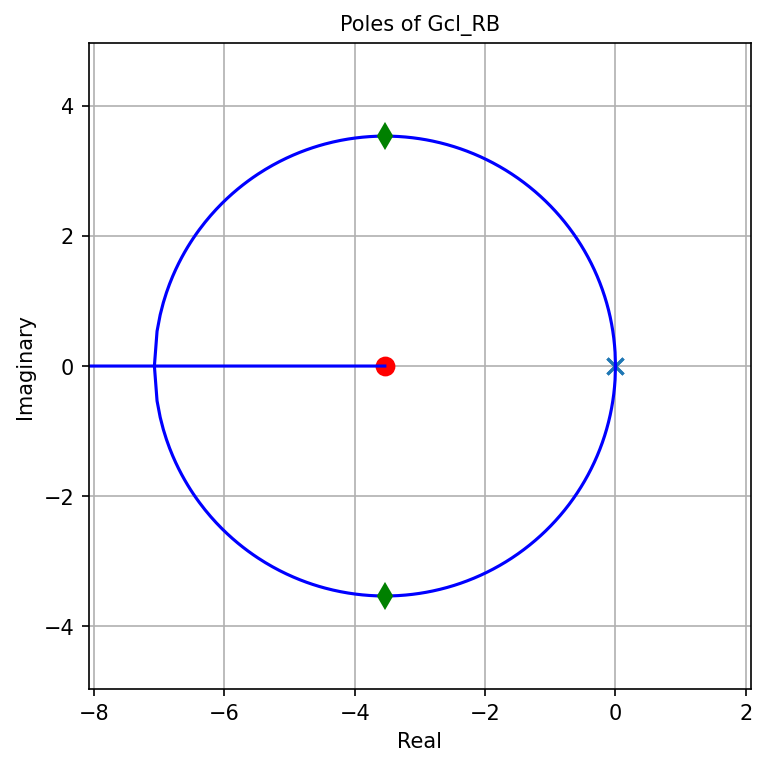

DC gain of the closed loop system is:  1.0


TransferFunction(array([ 275.000]), array([  11.000,   77.770,  275.000]))

In [26]:
# Loop TF
L_RB = G_RB * PD_RB

Gcl_RB = tf(Kp_RB*G_RB.num[0][0]*PD_RB.den[0][0], 
            np.polyadd(L_RB.den[0][0], L_RB.num[0][0]))

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlocus(L_RB, Root_Locus_gains(L_RB), grid=False,ax=ax)
plt.plot(Gcl_RB.poles().real, Gcl_RB.poles().imag, 'rd', markersize=10)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles of Gcl_RB')
plt.grid(True)
ax.axis('equal')
ax.set_xlim(-8,2)
color_rl(ax)
savefig("./figs/Sat_step1.pdf", dpi=600)
plt.show()

print("DC gain of the closed loop system is: ", Gcl_RB.dcgain())
Gcl_RB

In [27]:
# design parameters for the solar controller (outer)
zeta = 0.707
wn = w_flex

AA = np.array([[k*Gcl_RB.dcgain(), -b*Gcl_RB.dcgain()*wn**2],[b*Gcl_RB.dcgain(), k*Gcl_RB.dcgain()-2*b*Gcl_RB.dcgain()*zeta*wn]])
BB = np.array([-k+Jp*wn**2, -b+2*Jp*zeta*wn])
Kp_solar,Kd_solar = np.linalg.solve(AA,BB)

PD_solar = tf([Kd_solar, Kp_solar], [1])
print(PD_solar)

G_inner = G_solar*Gcl_RB
Gcl_solar = (1+Kp_solar)*G_inner/(1+G_inner*(Kp_solar+Kd_solar*s))
Gcl_solar = tf(np.trim_zeros(Gcl_solar.num[0][0], 'b'), np.trim_zeros(Gcl_solar.den[0][0], 'b'))
Gcl_solar = Gcl_solar.minreal()
print(Gcl_solar)

# Loop TF
L_solar = G_inner * PD_solar

<TransferFunction>: sys[106]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1.464 s + 0.07319
-----------------
        1

<TransferFunction>: sys[119]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


              1.341 s + 26.83
--------------------------------------------
s^4 + 7.12 s^3 + 28.18 s^2 + 45.01 s + 26.83




Found breakin/out at K = 1.073
At possible locations s = -1.365


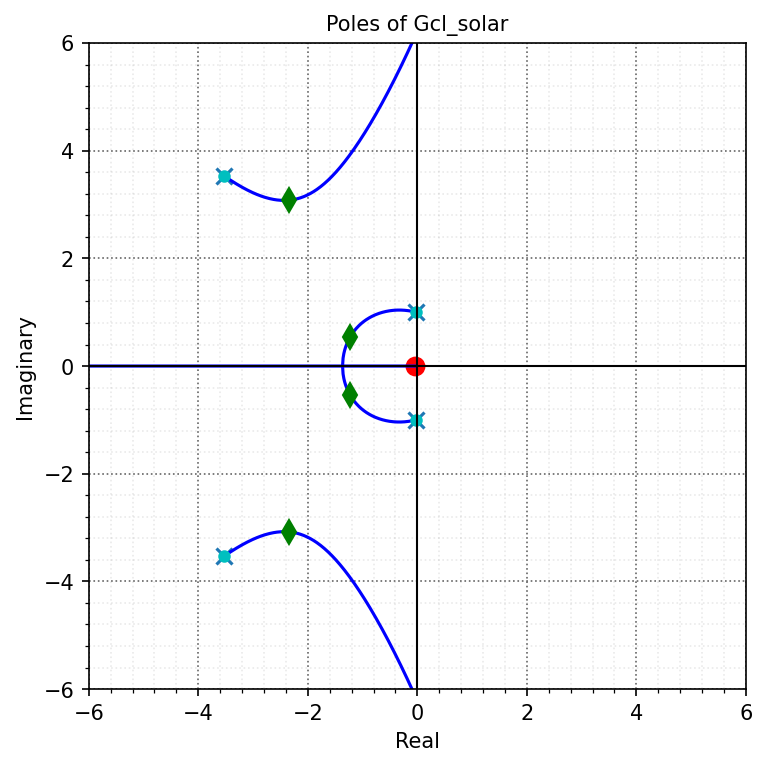

TransferFunction(array([   1.341,   26.830]), array([   1.000,    7.120,   28.183,   45.007,   26.830]))

In [28]:
fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlocus(L_solar, Root_Locus_gains(L_solar), grid=False,ax=ax)
plt.plot(Gcl_solar.poles().real, Gcl_solar.poles().imag, 'gd', markersize=10)
plt.plot(G_inner.poles().real, G_inner.poles().imag, 'c.', markersize=10)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles of Gcl_solar')
color_rl(ax)
nicegrid(ax)
ax.set_ylim(-6,6)
ax.set_xlim(-6,6)
savefig("./figs/Sat_step3.pdf", dpi=600)
plt.show()
Gcl_solar

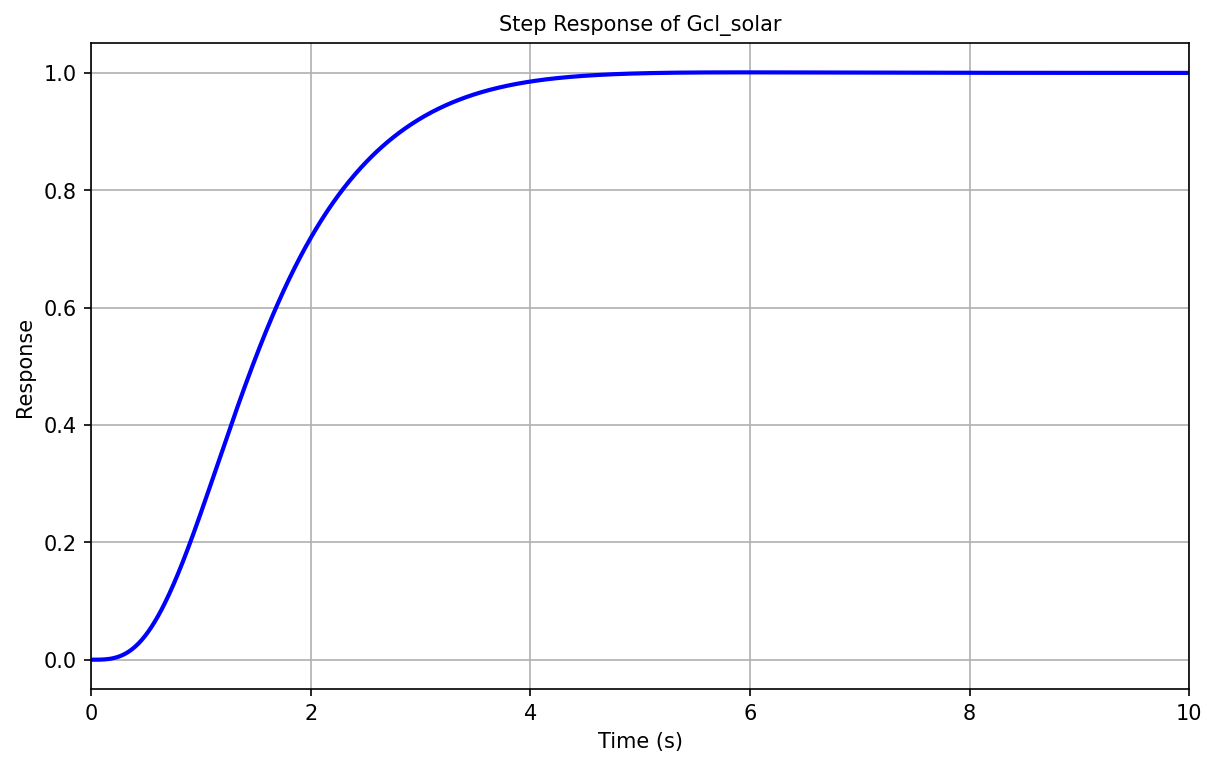

In [29]:
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
Tf = 10
y,t = step(Gcl_solar, T=np.linspace(0, Tf, int(Tf/Ts)))
plt.plot(t, y,'b')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Step Response of Gcl_solar')
plt.grid(True)
plt.show()